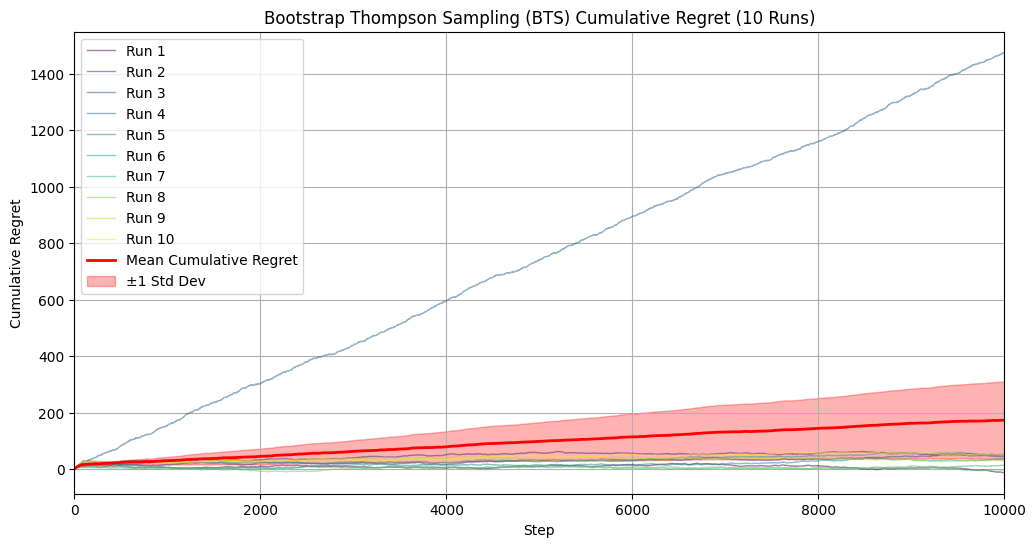

✅ BTS total execution time: 7.46 seconds


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os
from joblib import Parallel, delayed

# ✅ Load saved arms and rewards
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# ✅ BTS strategy
def bootstrap_ts(K, n, reward_lists, seed_offset=0, bootstrap_samples=1000):
    np.random.seed(42 + seed_offset)
    random.seed(42 + seed_offset)

    action_counts = np.zeros(K)
    cumulative_regrets = np.zeros(n)
    reward_history = [[] for _ in range(K)]  # Keep track of reward samples per arm

    true_means = np.array([np.mean(r) for r in reward_lists])
    best_mean = np.max(true_means)

    for t in range(n):
        sampled_means = np.zeros(K)

        for arm in range(K):
            if reward_history[arm]:  # 有历史数据才 bootstrap
                samples = np.random.choice(reward_history[arm], bootstrap_samples, replace=True)
                sampled_means[arm] = np.mean(samples)
            else:
                sampled_means[arm] = float('inf')  # 强制先探索没拉过的臂

        chosen_arm = np.argmax(sampled_means)
        reward = random.choice(reward_lists[chosen_arm])
        reward_history[chosen_arm].append(reward)

        action_counts[chosen_arm] += 1

        regret = best_mean - reward
        cumulative_regrets[t] = regret if t == 0 else cumulative_regrets[t - 1] + regret

    return cumulative_regrets

# ✅ Parameters
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())
K = len(arms)
n = 10000
num_runs = 10

# ✅ Start timing
start_time = time.time()

# ✅ Run BTS in parallel
all_cumulative_regrets = Parallel(n_jobs=-1)(
    delayed(bootstrap_ts)(K, n, reward_lists, seed_offset=i) for i in range(num_runs)
)
all_cumulative_regrets = np.array(all_cumulative_regrets)

# ✅ Calculate mean & std error
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = np.std(all_cumulative_regrets, axis=0) / np.sqrt(num_runs)

# ✅ Plotting
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))
plt.figure(figsize=(12, 6))
for i in range(num_runs):
    plt.plot(all_cumulative_regrets[i], color=colors[i], alpha=0.5, linewidth=1, label=f'Run {i+1}')
plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n),
                 mean_cumulative_regrets - stderr_cumulative_regrets,
                 mean_cumulative_regrets + stderr_cumulative_regrets,
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('Bootstrap Thompson Sampling (BTS) Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

# ✅ Print timing
end_time = time.time()
print(f"✅ BTS total execution time: {end_time - start_time:.2f} seconds")


In [2]:
# Bootstrap Thompson Sampling retains the exploratory efficiency of TS while eliminating dependence on specific prior distributions, making it more suitable for complex, non-modelable reward scenarios. Your implementation combines parallel acceleration and visualisation, making it ideal as an algorithm comparison baseline for practical applications such as recommendation systems and ad placement.